<a href="https://colab.research.google.com/github/maren-gonzalez/deteccion-deepfakes/blob/main/deteccion_deepfakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
#Instalaciones para descargar las imágenes al entorno
!pip install gdown --upgrade --no-cache-dir
!pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f7eb59242631ebefe6ee226a4cf288e0a0ae185cb996ffb67982cd9e1b1f68d7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
#Imports
from google.colab import auth
from googleapiclient.discovery import build
import pandas as pd
import gdown
import io
import os
from googleapiclient.http import MediaIoBaseDownload

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import shutil
import random
from PIL import Image
from torchvision import transforms, datasets, models

import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as F

import torch
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Crear dataset

In [ ]:
# Preparar el entorno para descargar los archivos
auth.authenticate_user()
drive_service = build('drive', 'v3')

# Links de acceso público a las carpetas con las imágenes
folder_ia = '14xM8jjGl7QPMDUkti6iUl4M1m6qcs4L1'   # Modificar link en caso de usar otra carpeta
folder_real = '1ruvbcczrUZ2W6rmmC7TvLUQxtOD_Cg3J' # Modificar link en caso de usar otra carpeta

# Función para descargar las imágenes al entorno
def download_files_from_folder(folder_id, output_folder, label):
  query = f"'{folder_id}' in parents"
  results = drive_service.files().list(q=query, fields='nextPageToken, files(id, name)').execute()
  items = results.get('files', [])

  while results.get('nextPageToken'):
    results = drive_service.files().list(q=query, fields='nextPageToken, files(id, name)', pageToken=results.get('nextPageToken')).execute()
    items.extend(results.get('files', []))

  if not items:
    print('No hay archivos en la carpeta.')
    return

  carpeta_label = os.path.join(output_folder, label)
  os.makedirs(carpeta_label, exist_ok=True)

  for item in items:
    file_id = item['id']
    file_name = item['name']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
      status, done = downloader.next_chunk()
    with open(os.path.join(carpeta_label, file_name), 'wb') as f:
      f.write(fh.getbuffer())

os.makedirs('dataset', exist_ok=True)

download_files_from_folder(folder_ia, 'dataset', 'ia')
print(f"Carpeta fotos_ia completada.")
download_files_from_folder(folder_real, 'dataset', 'real')
print(f"Carpeta fotos_real completada.")

Carpeta fotos_ia completada.
Carpeta fotos_real completada.


In [ ]:
num_ia_images = len(os.listdir('dataset/ia'))
num_real_images = len(os.listdir('dataset/real'))

print(f"Número de imágenes en dataset/ia: {num_ia_images}")
print(f"Número de imágenes en dataset/real: {num_real_images}")

Número de imágenes en dataset/ia: 1240
Número de imágenes en dataset/real: 1096


# Preparación de datos

In [ ]:
# Preparación de las imágenes

# Transform
transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Cambiar resolución de imagen
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # Normalizar los píxeles
  ])

data = datasets.ImageFolder('dataset', transform=transform)

# Comprobar labels
print(f"Labels: {data.classes}")
print(f"Mapping de labels: {data.class_to_idx}")

Labels: ['ia', 'real']
Mapping de labels: {'ia': 0, 'real': 1}


In [ ]:
# Separación de sets
train_size = int(len(data)*0.7) # 70% de contenido para el training set
val_size = int(0.15 * len(data)) # 15% de contenido para el validation set
test_size = int(len(data) - train_size - val_size) # 15% de contenido para el test set

train, val, test = random_split(data, [train_size, val_size, test_size])

# Crear los DataLoaders
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=True)

# Creación de modelos

In [ ]:
# Crear los modelos

# Resnet18 (pretrained)
modelo_resnet = models.resnet18(pretrained=True)
modelo_resnet.fc = nn.Linear(modelo_resnet.fc.in_features, 2)

# MobileNetV2 (pretrained)
modelo_mobilenet = models.mobilenet_v2(pretrained=True)
modelo_mobilenet.classifier[1] = nn.Linear(modelo_mobilenet.classifier[1].in_features, 2)

# CNN
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2, 2)

    # Fully connected layers
    self.fc1 = nn.Linear(128 * 28 * 28, 512)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    # Flatten
    x = x.view(-1, 128 * 28 * 28)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

modelo_cnn = CNN()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.1MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [ ]:
# Optimizar modelos
criterion = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(modelo_resnet.parameters(), lr=0.001)
mobilenet_optimizer = torch.optim.Adam(modelo_mobilenet.parameters(), lr=0.001)
cnn_optimizer = torch.optim.Adam(modelo_cnn.parameters(), lr=0.001)

In [ ]:
# Preparar el device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Entrenar modelos

In [ ]:
def evaluation(model, dataLoader, device):
  # Poner modelo en modo evaluación
  model.eval()

  preds = []
  labels = []

  with torch.no_grad():
    for input, label in dataLoader:
      input = input.to(device)
      label = label.to(device)

      output = model(input)
      _, pred = torch.max(output, 1)

      preds.extend(pred.cpu().numpy())
      labels.extend(label.cpu().numpy())

  # Calcular métricas
  accuracy = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average='weighted')
  recall = recall_score(labels, preds, average='weighted')
  f1 = f1_score(labels, preds, average='weighted')
  matrix = confusion_matrix(labels, preds)

  results = {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1 measure': f1,
      'confusion matrix': matrix
  }
  return results

In [ ]:
def training(model, train_loader, val_loader, criterion, optimizer, epochs, device):
  model.to(device)

  best_acc = 0.0
  for epoch in range(epochs):
    # Poner modelo en modo evaluación
    model.train()

    # Fase entrenamiento
    running_loss = 0.0
    for input, label in train_loader:
      input, label = input.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    # Fase validación
    metrics = evaluation(model, val_loader, device)
    accuracy = metrics['accuracy']

    print(f"Epoch {epoch + 1}/{epochs}|   Train loss: {running_loss/len(train_loader):.4f}|   Val accuracy: {accuracy:.4f}")

    # Guardar el modelo
    if accuracy > best_acc:
      best_acc = accuracy
      torch.save(model.state_dict(), f"best_{type(model).__name__}.pth")

  print(f"Training completado!")

In [ ]:
models = {
    'ResNet18': (modelo_resnet, resnet_optimizer),
    'MobileNet': (modelo_mobilenet, mobilenet_optimizer),
    'CNN': (modelo_cnn, cnn_optimizer)
}

for name, (model, optimizer) in models.items():
    print(f"\nEntrenando {name}")
    training(model, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)


Entrenando ResNet18
Epoch 1/5|   Train loss: 0.0004|   Val accuracy: 1.0000
Epoch 2/5|   Train loss: 0.0087|   Val accuracy: 0.9914
Epoch 3/5|   Train loss: 0.0757|   Val accuracy: 0.9914
Epoch 4/5|   Train loss: 0.0191|   Val accuracy: 0.9886
Epoch 5/5|   Train loss: 0.0079|   Val accuracy: 1.0000
Training completado!

Entrenando MobileNet
Epoch 1/5|   Train loss: 0.0790|   Val accuracy: 1.0000
Epoch 2/5|   Train loss: 0.0192|   Val accuracy: 1.0000
Epoch 3/5|   Train loss: 0.0090|   Val accuracy: 1.0000
Epoch 4/5|   Train loss: 0.0033|   Val accuracy: 1.0000
Epoch 5/5|   Train loss: 0.0013|   Val accuracy: 1.0000
Training completado!

Entrenando CNN
Epoch 1/5|   Train loss: 0.5270|   Val accuracy: 0.9457
Epoch 2/5|   Train loss: 0.0380|   Val accuracy: 0.9943
Epoch 3/5|   Train loss: 0.0183|   Val accuracy: 0.9743
Epoch 4/5|   Train loss: 0.0075|   Val accuracy: 0.9971
Epoch 5/5|   Train loss: 0.0005|   Val accuracy: 1.0000
Training completado!


# Evaluation

In [ ]:
# Evaluar modelos
models = {
    'ResNet18': modelo_resnet,
    'MobileNetV2': modelo_mobilenet,
    'Custom CNN': modelo_cnn
}

results = {}
for name, model in models.items():
  print(f"Evaluando modelo: {name}")
  model.load_state_dict(torch.load(f"best_{type(model).__name__}.pth"))
  results[name] = evaluation(model, test_loader, device)

# Imprimir resultados
for model, metrics in results.items():
    print(f'\n{model} Performance:')
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1 measure']:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion matrix'])

Evaluando modelo: ResNet18
Evaluando modelo: MobileNetV2
Evaluando modelo: Custom CNN

ResNet18 Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Confusion Matrix:
[[188   0]
 [  0 163]]

MobileNetV2 Performance:
Accuracy: 0.9915
Precision: 0.9916
Recall: 0.9915
F1-Score: 0.9914
Confusion Matrix:
[[188   0]
 [  3 160]]

Custom CNN Performance:
Accuracy: 0.9915
Precision: 0.9916
Recall: 0.9915
F1-Score: 0.9914
Confusion Matrix:
[[188   0]
 [  3 160]]


# Aplicación al mundo real

In [ ]:
# Añade manualmente las imagenes que se quieran comprobar en la carpeta
os.makedirs('prediccion', exist_ok=True)

Clasificando imágenes
Error processing prediccion/descarga (1).jpeg: 'list' object is not callable


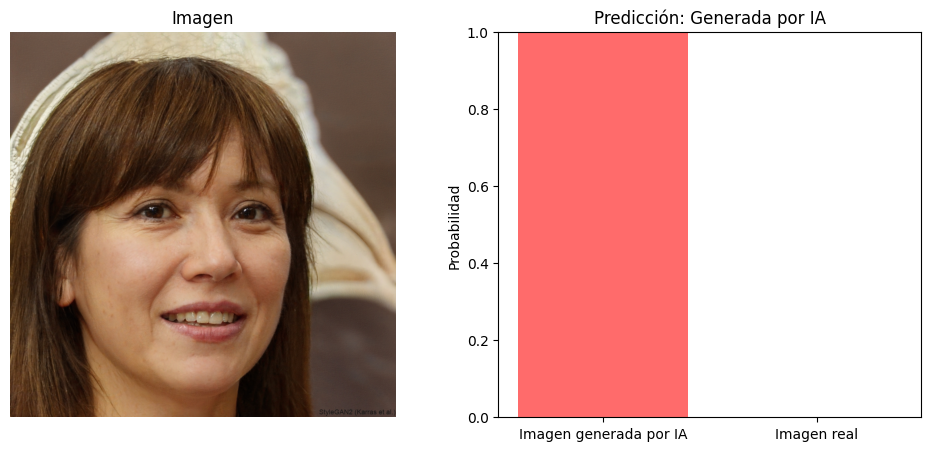

In [43]:
# Seleccionamos el modelo con mejor performance
modelo = models.resnet18(pretrained=False)
modelo.fc = nn.Linear(modelo.fc.in_features, 2)
state_dict = torch.load('/content/best_ResNet.pth')
modelo.load_state_dict(state_dict)
modelo.to(device)
modelo.eval()

# Predicción sin explicación LIME para comprobaciones rápidas
def predecir_clase(image_path, model, transform, device):
  try:
      image = Image.open(image_path).convert('RGB')
      tensor = transform(image).unsqueeze(0).to(device)

      with torch.no_grad():
        output = model(tensor)
        _, pred = torch.max(output, 1)
        probs = F.softmax(output, dim=1)

      prob_ia = probs[0][0].item()
      prob_real = probs[0][1].item()

      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.imshow(image)
      plt.axis('off')
      plt.title('Imagen')

      plt.subplot(1, 2, 2)
      bars = plt.bar(['Imagen generada por IA', 'Imagen real'], [prob_ia, prob_real], color=['#FF6B6B', '#51CF66'])
      plt.ylim(0, 1)
      plt.title(f'Predicción: {"Generada por IA" if pred == 0 else "Imagen real"}')
      plt.ylabel('Probabilidad')

      for bar in bars.patches():
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}', ha='center', va='bottom', fontsize=12)

      plt.tight_layout()
      plt.show()

      return pred.item(), probs[0].cpu().numpy()

  except Exception as e:
    print(f"Error processing {image_path}: {str(e)}")
    return None, None

print(f"Clasificando imágenes")
for img in os.listdir('prediccion'):
  if img.lower().endswith(('.png', '.jpg', '.jpeg')):
    img_path = os.path.join('prediccion', img)
    pred, probs = predecir_clase(img_path, modelo, transform, device)
    if pred is not None:
      print(f"Prediction: {'AI Generated' if pred == 0 else 'Real'}")
      print(f"Probabilities: AI={probs[0]:.4f}, Real={probs[1]:.4f}")
      print("-" * 50)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Clasificando imágenes...


  0%|          | 0/1000 [00:00<?, ?it/s]

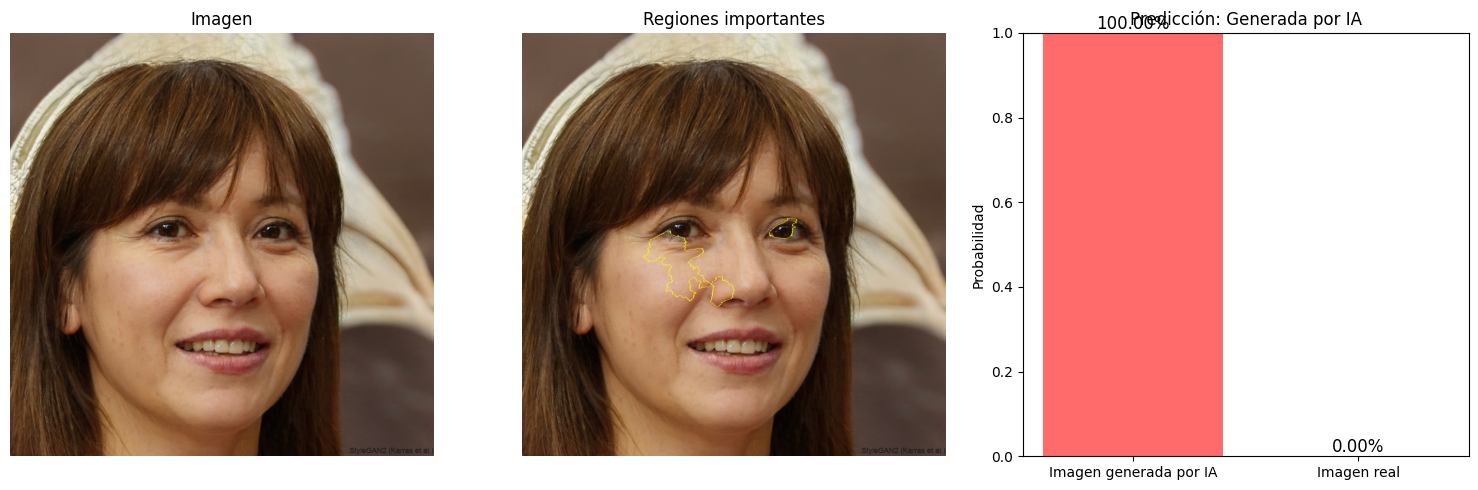

Predicción: Imagen generada por IA


In [42]:
# Función para saber que parte de la imagen ha influenciado el resultado
def explicar_LIME(image_path, model, transform, device, top_labels=2, num_samples=1000):
  try:
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)

    def LIME(images):
        batch = torch.stack([transform(Image.fromarray(image)) for image in images]).to(device)
        with torch.no_grad():
          logits = model(batch)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    # Conseguir la explicación
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image_np, LIME, top_labels=2, num_samples=1000)
    pred = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(pred, positive_only=True, num_features=5, hide_rest=False)

    # Visualizar imagen
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Imagen')
    plt.axis('off')

    # Visualizar explicación
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('Regiones importantes')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    probs = LIME(np.expand_dims(image_np, axis=0))[0]
    bars = plt.bar(['Imagen generada por IA', 'Imagen real'], [probs[0], probs[1]], color=['#FF6B6B', '#51CF66'])
    plt.ylim(0, 1)
    plt.title(f'Predicción: {"Generada por IA" if pred == 0 else "Imagen real"}')
    plt.ylabel('Probabilidad')

    for bar in bars.patches:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()
    return pred, probs

  except Exception as e:
    print(f"Error procesando la imagen {image_path}: {str(e)}")
    return None, None

print(f"Clasificando imágenes...")
for img in os.listdir('prediccion'):
  if img.lower().endswith(('.png', '.jpg', '.jpeg')):
    img_path = os.path.join('prediccion', img)
    pred, probs = explicar_LIME(img_path, modelo, transform, device)
    if pred is not None:
        print(f"Predicción: {'Imagen generada por IA' if pred == 0 else 'Imagen real'}")

# Debug

In [ ]:
###DEBUG --> borrar los contenidos de una carpeta###
import os
import shutil

carpeta = "/content/dataset"

for archivo in os.listdir(carpeta):
    ruta_completa = os.path.join(carpeta, archivo)
    if os.path.isfile(ruta_completa) or os.path.islink(ruta_completa):
        os.unlink(ruta_completa)
    elif os.path.isdir(ruta_completa):
        shutil.rmtree(ruta_completa)
